# 7.2.1. Диагностика стационарности ряда в Python

# 1. Стационарность

## 1.1. Определение стационарности

**Стационарный временной ряд** — это временной ряд, статистические свойства (среднее, дисперсия) которого не меняются со временем. Таким образом, временные ряды с трендами или сезонностью не являются стационарными, потому что тренд и сезонность будут влиять на значение временного ряда в разные моменты времени. 

С другой стороны, временной ряд, являющийся белым шумом, является стационарным, поскольку он будет выглядеть примерно одинаково в любой момент времени. Некоторые случаи могут сбивать с толку — например, временной ряд с циклическим поведением (но без тренда или сезонности) является стационарным. Это связано с тем, что циклы не имеют фиксированной длины, поэтому мы не знаем, где будут пики и спады циклов.

Примером стационарного временного ряда является гауссовский белый шум. 

Гауссовский белый шум задаётся формулой: 

$$y_t = iid N(0,\sigma^2),$$ 

где iid обозначает, что значения временного ряда в любой момент времени являются независимыми и одинаково распределёнными случайными величинами (а значит, вместе они не коррелируют). Гауссовский белый шум имеет постоянное среднее, равное нулю ($E[Y_t] = 0$), и постоянную дисперсию, равную $\sigma^2$ ($Var[Y_t] = \sigma^2$).

![image.png](attachment:image.png)

## 1.2. Важность стационарности

Процессы стационарных временных рядов `легче анализировать и моделировать`, поскольку основное предположение состоит в том, что `их свойства не зависят от времени` и будут такими же в будущем, как и в предыдущий исторический период времени.

`Большинство методов` прогнозирования `предназначены для работы со стационарными` временными рядами. 

Первым шагом в процессе прогнозирования обычно является преобразование нестационарного ряда в стационарный. Прогнозировать стационарный ряд относительно проще, а прогнозы будут более надёжными. 

Например, мы знаем, что линейная регрессия работает лучше всего, если предикторы (переменные X) не коррелируют друг с другом. Таким образом, стационаризация ряда решает эту проблему, поскольку устраняет любую стойкую автокорреляцию, тем самым делая предикторы (лаги временного ряда) в моделях прогнозирования почти независимыми.

`AR-модели, МА-модели и ARIMA-модели требуют стационарный временной ряд.` Методы экспоненциального сглаживания применяются для нестационарных временных рядов. Применение методов экспоненциального сглаживания для стационарных рядов не будет ошибкой, но само по себе субоптимально. Модели скользящего среднего, предсказывающие на основе скользящего среднего N последних наблюдений, могут работать с некоторыми видами нестационарных данных, но будут плохо работать с трендами и сезонностью.

## 1.3. Способы определения нестационарности

Существует несколько способов определить нестационарность временного ряда:
- разбить временной ряд на две части и вычислить описательные статистики (если они отличаются, ряд не является стационарным);
- построить ящичковые диаграммы для соответствующих моментов времени и оценить изменение размаха;
- построить графики автокорреляционной функции и частной автокорреляционной функции;
- применить тесты на единичные корни: расширенный тест Дикки — Фуллера (ADF-тест), тест Филлипса — Перрона (РР-тест), тест Квятковского — Филлипса — Шмидта — Шина (KPSS-тест).

Для преобразования нестационарного ряда в стационарный обычно применяется:
- **дифференцирование ряда** (переход к попарным разностям его соседних значений), которое позволяет стабилизировать среднее значение временного ряда, удаляя изменения уровня временного ряда и, таким образом, удаляя (уменьшая) тренд и сезонность;
- логарифмирование, которое позволяет стабилизировать дисперсию временного ряда.

## 2. Стационарность в Python

Проиллюстрируем диагностику стационарности на конкретном примере. 

Мы будем прогнозировать ежемесячное количество авиапассажиров. В работе мы будем использовать набор данных Airline Passengers. В нём содержится информация об авиаперевозках за некоторый период времени. Каждая запись содержит данные о количестве авиапассажиров в тысячах. 

Всего в наборе присутствует 144 ежемесячных наблюдения с 1949 по 1960 год.

In [ ]:
# Импортируем библиотеки NumPy и pandas
import numpy as np
import pandas as pd

# Импортируем необходимые функции
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.compat.python import lzip
from scipy import stats

# Импортируем библиотеку matplotlib для построения графиков
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Загружаем данные об авиаперевозках
air_passengers = pd.read_csv(
    './data/AirPassengers.csv', 
    header=0, 
    index_col=0, 
    parse_dates=True, 
    squeeze=True)

In [ ]:
# Печатаем первые десять наблюдений
print(air_passengers.head(10))

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64


Теперь визуализируем временной ряд.

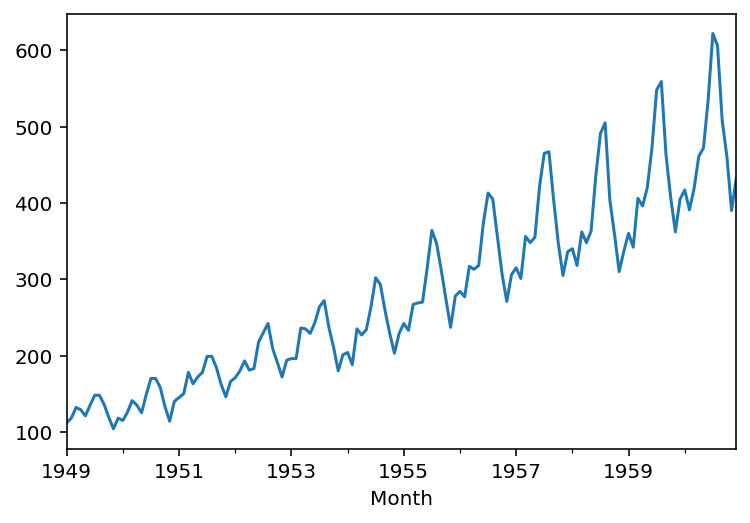

In [ ]:
# Визуализируем временной ряд
air_passengers.plot();

На графике видно, что в данных присутствует восходящий тренд — увеличение количества пассажиров со временем. 

Кроме того, можно наблюдать сезонность, связанную с ежегодным туристическим сезоном. И похоже, что амплитуда сезонных колебаний растёт от года к году, что предполагает мультипликативную зависимость.

## 2.1. Ящичковые диаграммы
Давайте убедимся в нестационарности нашего временного ряда, содержащего информацию об авиаперевозках. Мы рассмотрим данные по месяцам для каждого года и сравним, как изменяется разброс значений от года к году. Для анализа воспользуемся ящичковыми диаграммами.

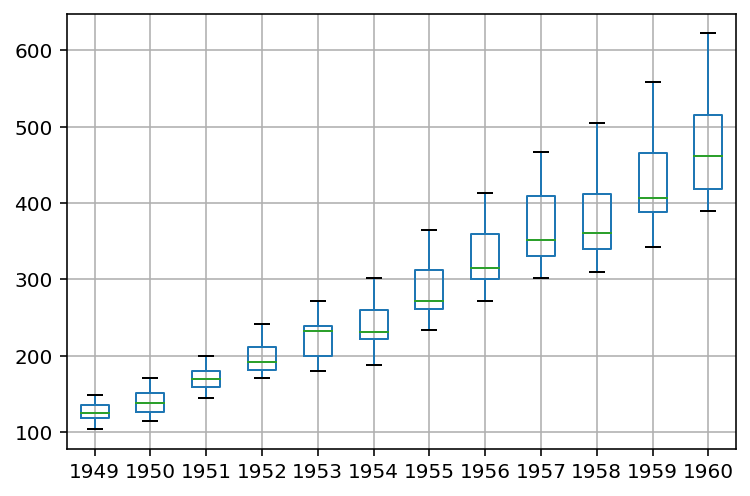

In [ ]:
# Группируем данные по годам
groups = air_passengers['1949':'1960'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
# Для каждого года строим ящичковую диаграмму
years.boxplot();

Изменение размаха данных (расстояния от края нижнего хвоста до края верхнего) указывает на восходящий тренд с течением времени, что также подтверждает нестационарность нашего временного ряда.

## 2.2. Графики автокорреляционной функции и частной автокорреляционной функции

Теперь для проверки стационарности, определения тренда и сезонной компоненты во временном ряду применим аппарат корреляционного анализа. 

Корреляция характеризует силу связи между наблюдениями. Если связь между наблюдениями присутствует, то данные называются коррелированными. 

`Когда определяется сильная связь между значениями одного временного ряда, то имеет место автокорреляция.` 

В этом случае вычисляется корреляция между временным рядом и его копией, сдвинутой на заданное количество интервалов (величину лага). Здесь и далее лаги и сдвиги используются как синонимы.

Смысл корреляционного анализа заключается в следующем: детерминированная составляющая характеризуется плавными изменениями значений ряда, то есть соседние значения ряда не должны сильно отличаться, и, следовательно, между ними присутствует сильная связь. Если значения ряда в большей степени обусловлены случайной составляющей и соседние значения могут существенно отличаться друг от друга, то корреляция будет меньше.

Главными инструментами корреляционного анализа будут (полная) автокорреляция и частная автокорреляция. 

(Полная) автокорреляция даёт нам значения автокорреляции текущего наблюдения ряда с его сдвинутыми на определённое количество шагов назад наблюдениями — лагами. Проще говоря, автокорреляция показывает, насколько сильно текущее наблюдение ряда связано с его прошлыми наблюдениями. 

Полученные коэффициенты автокорреляции для соответствующих лагов (включая нулевой) вместе с доверительным интервалом представляют собой автокорреляционную функцию (autocorrelation function, ACF). Значение коэффициента автокорреляции при нулевом лаге равно 1, поскольку ряд полностью коррелирован с самим собой. Обратите внимание, что в других программах нулевой сдвиг может не выводиться. Лаг, после которого график ACF впервые пересекает границы доверительного интервала, определяет порядок МА-процесса.

Давайте вычислим коэффициент автокорреляции для k = 2.
Загружаем данные, содержащие временной ряд, и визуализируем их.

In [ ]:
# Загружаем данные о продажах
sales = pd.read_csv(
    './data/sales.csv', 
    index_col=0,
    parse_dates=True, 
    squeeze=True)

# Печатаем значения временного ряда по продажам
pd.DataFrame(sales).reset_index()

,Month,Sales
0,2019-01-01,23.4
1,2019-02-01,24.1
2,2019-03-01,44.4
3,2019-04-01,25.5
4,2019-05-01,19.2
5,2019-06-01,37.1
6,2019-07-01,45.0
7,2019-08-01,61.8
8,2019-09-01,56.7
9,2019-10-01,62.3


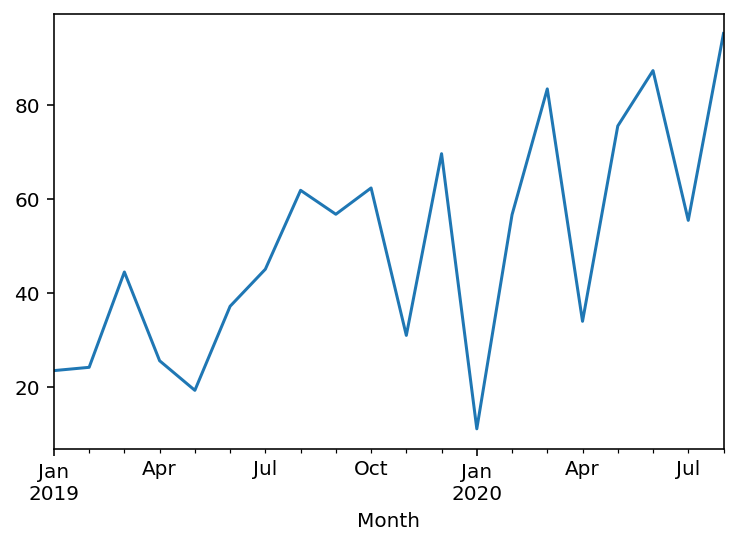

In [ ]:
# Визуализируем ряд по продажам
sales.plot();

Запишем в отдельные переменные длину и величину лага временного ряда. Затем вычислим среднее значение и дисперсию временного ряда (в знаменателе будем использовать деление на Т — длину ряда).

In [ ]:
# Записываем информацию о лаге и длине временного ряда
k = 2
T = len(sales)

print('Лаг: ', k)
print('Длина временного ряда: ', T)

Лаг:  2
Длина временного ряда:  20


In [ ]:
# Вычисляем среднее временного ряда
mean = sales.mean()

# Вычисляем дисперсию временного ряда
variance = sales.var(ddof=0)

print('Среднее временного ряда: ', mean)
print('Дисперсия временного ряда: ', variance)

Среднее временного ряда:  49.915
Дисперсия временного ряда:  564.3672750000002


In [ ]:
# Распишем формулу вычисления дисперсии
variance = sum((sales - mean) ** 2) / T
variance

564.3672750000002

Теперь создаём два сравниваемых ряда для лага 2.

In [ ]:
# Создаём исходный ряд
orig_series = sales.head(T - k).reset_index(drop=True)

# Создаём сдвинутый ряд
lagged_series = sales.tail(T - k).reset_index(drop=True)

In [ ]:
# Длина полученных рядов 18 (было 20), так как два значения — нулевые

res=pd.DataFrame()
res['orig_series']=orig_series
res['lagged_series']=lagged_series

res

,orig_series,lagged_series
0,23.4,44.4
1,24.1,25.5
2,44.4,19.2
3,25.5,37.1
4,19.2,45.0
5,37.1,61.8
6,45.0,56.7
7,61.8,62.3
8,56.7,30.9
9,62.3,69.6


In [ ]:
# Вычисляем коэффициент автокорреляции для лага 2
autocovariance = sum((orig_series - mean) * (lagged_series - mean)) / T
coeff_for_lag2 = autocovariance / variance
coeff_for_lag2

0.26922207262991976

Можно написать функцию, которая автоматически вычислит значения автокорреляции для соответствующих лагов. Однако сначала надо написать функцию автоковариации.

In [ ]:
# Пишем функцию автоковариации
def autocovariance(series, lag):
    len_series = len(series)
    mean_series = np.mean(series)

    covariances = []
    for index in range(lag, len_series):
        # Вычисляем простую ковариацию, её легко вычислить с помощью np.cov,
        # но в образовательных целях вычисляем её самостоятельно
        covariance = (series[index] - mean_series) * (series[index - lag] - mean_series)
        covariances.append(covariance)

    autocovariance = np.sum(covariances) / len_series
    return autocovariance

А вот теперь пишем функцию вычисления автокорреляции, внутри которой используется ранее написанная нами функция вычисления автоковариации.

In [ ]:
# Пишем функцию автокорреляции
def autocorrelation_function(series, max_lags=20):
    lag_list = list(range(max_lags))
    autocovariances = []
    for lag in lag_list:  # Вычисляем автоковариации для каждого лага
        autocovariances.append(autocovariance(series, lag))

    autocorrelations = np.divide(autocovariances, autocovariances[0])
    return autocorrelations

In [ ]:
# Вычисляем автокорреляцию с помощью нашей функции
autocorrelation_function(sales)

array([ 1.        ,  0.11748088,  0.26922207,  0.3714417 , -0.13980713,
        0.0802596 ,  0.04020149, -0.17649102,  0.11544519,  0.01885979,
        0.01247395, -0.00168609,  0.02763411, -0.26748091, -0.20173766,
       -0.17425376, -0.24623709, -0.12249163, -0.11645493, -0.10637858])

Теперь импортируем функцию acf() для вычисления значений автокорреляционной функции и plot_acf() для построения графика автокорреляционной функции.

In [ ]:
# Импортируем функции для вычисления значений автокорреляционной 
# функции и построения графика автокорреляционной функции
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

Давайте выведем значения автокорреляционной функции с помощью функции acf(). Сравним полученное значение для лага 2 со значением, вычисленным вручную. Они совпадают.

In [ ]:
# Выведем значения автокорреляционной функции
k = len(sales) - 1
acf(sales, nlags=k)

array([ 1.        ,  0.11748088,  0.26922207,  0.3714417 , -0.13980713,
        0.0802596 ,  0.04020149, -0.17649102,  0.11544519,  0.01885979,
        0.01247395, -0.00168609,  0.02763411, -0.26748091, -0.20173766,
       -0.17425376, -0.24623709, -0.12249163, -0.11645493, -0.10637858])

Параметр nlags функции acf() задаёт количество лагов. Поскольку у нас 20 значений — моментов времени, у нас будет 19 лагов, то есть длина ряда — 1.

У нас будет 20 коэффициентов автокорреляции для нулевого лага и 19 ненулевых лагов. Эти коэффициенты показывают автокорреляционную функцию. Все коэффициенты совпадают с коэффициентами, вычисленными с помощью нашей функции autocorrelation_function().
Кроме того, можно вывести границы доверительного интервала для каждого коэффициента автокорреляции. По умолчанию используется 95%-ный доверительный интервал.

In [ ]:
# Можно вывести границы доверительного интервала
# для каждого коэффициента автокорреляции
acf_ = acf(sales, nlags=k, alpha=0.05)
acf_

(array([ 1.        ,  0.11748088,  0.26922207,  0.3714417 , -0.13980713,
         0.0802596 ,  0.04020149, -0.17649102,  0.11544519,  0.01885979,
         0.01247395, -0.00168609,  0.02763411, -0.26748091, -0.20173766,
        -0.17425376, -0.24623709, -0.12249163, -0.11645493, -0.10637858]),
 array([[ 1.        ,  1.        ],
        [-0.32078039,  0.55574215],
        [-0.1750468 ,  0.71349094],
        [-0.1031296 ,  0.84601301],
        [-0.66727099,  0.38765673],
        [-0.45427445,  0.61479365],
        [-0.49664222,  0.5770452 ],
        [-0.71391265,  0.36093061],
        [-0.43299606,  0.66388643],
        [-0.5342293 ,  0.57194888],
        [-0.54073865,  0.56568654],
        [-0.55495271,  0.55158053],
        [-0.52563349,  0.58090172],
        [-0.82101356,  0.28605174],
        [-0.77956333,  0.37608801],
        [-0.76545297,  0.41694545],
        [-0.84722033,  0.35474615],
        [-0.74255022,  0.49756697],
        [-0.74114402,  0.50823416],
        [-0.73522367, 

In [ ]:
# Запишем информацию только о коэффициентах автокорреляции
acf_ = acf_[0]
# Фиксируем размер выборки
nobs = len(sales)
# Задаём уровень значимости
alpha = 0.05
# Создаём массив, в которой будем записывать 
# значения дисперсии коэффициентов корреляции,
# имеет ту же длину, что и массив acf_
varacf = np.ones_like(acf_) / nobs
# Помним, что по формуле VAR(r_0)=0
varacf[0] = 0
# Помним, что по формуле VAR(r_1)=1/N
varacf[1] = 1.0 / nobs
# Вычисляем VAR для всех лагов, начиная с лага 2,
# по формуле 1 + 2 * sum_{i=1}^{k-1}r_i^{2}, k>1
varacf[2:] *= 1 + 2 * np.cumsum(acf_[1:-1] ** 2)

In [ ]:
# Вычисляем пределы погрешности
interval = stats.norm.ppf(1 - alpha / 2.0) * np.sqrt(varacf)
interval

array([0.        , 0.43826127, 0.44426887, 0.47457131, 0.52746386,
       0.53453405, 0.53684371, 0.53742163, 0.54844125, 0.55308909,
       0.5532126 , 0.55326662, 0.5532676 , 0.55353265, 0.57782567,
       0.59119921, 0.60098324, 0.62005859, 0.62468909, 0.62884509])

In [ ]:
# Вычисляем границы доверительного интервала
confint = np.array(lzip(acf_ - interval, acf_ + interval))
confint

array([[ 1.        ,  1.        ],
       [-0.32078039,  0.55574215],
       [-0.1750468 ,  0.71349094],
       [-0.1031296 ,  0.84601301],
       [-0.66727099,  0.38765673],
       [-0.45427445,  0.61479365],
       [-0.49664222,  0.5770452 ],
       [-0.71391265,  0.36093061],
       [-0.43299606,  0.66388643],
       [-0.5342293 ,  0.57194888],
       [-0.54073865,  0.56568654],
       [-0.55495271,  0.55158053],
       [-0.52563349,  0.58090172],
       [-0.82101356,  0.28605174],
       [-0.77956333,  0.37608801],
       [-0.76545297,  0.41694545],
       [-0.84722033,  0.35474615],
       [-0.74255022,  0.49756697],
       [-0.74114402,  0.50823416],
       [-0.73522367,  0.52246651]])

Теперь с помощью функции plot_acf() построим график автокорреляционной функции.

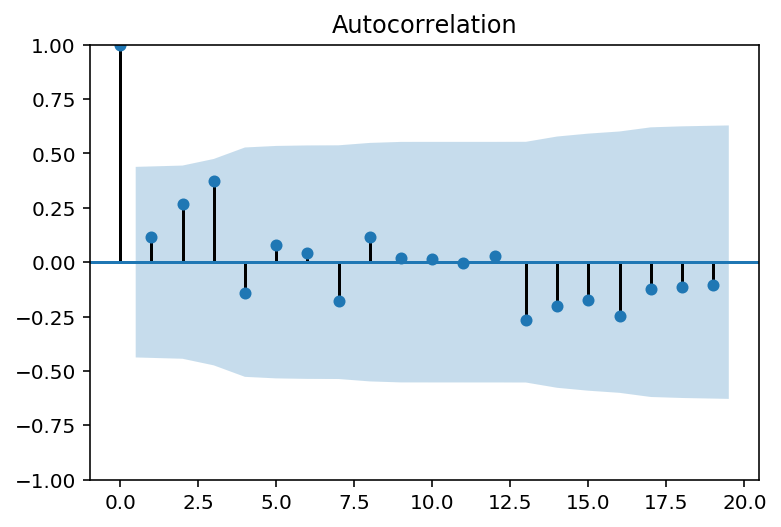

In [ ]:
# Строим график автокорреляционной функции
plot_acf(sales, lags=k);

По оси абсцисс откладываются сдвиги (включая нулевой сдвиг), по оси ординат — значения коэффициентов автокорреляции. Синим фоном изображены пределы погрешности, прибавленные к нулевым значениям коэффициентов автокорреляции. Таким образом, если коэффициент автокорреляции выходит за пределы синего фона, то он является значимым.

Для нестационарного временного ряда значение в первом лаге, то есть ACF(1), близко к единице, а затем график автокорреляционной функции медленно затухает. 

- Если ряд содержит тренд, то коэффициент автокорреляции значителен для первых нескольких сдвигов ряда, а в дальнейшем медленно стремится к нулю. 

- Если ряд содержит сезонную компоненту, то коэффициент автокорреляции будет большим для значений сдвига, равных периоду сезонной составляющей или кратных ему. 

- Для стационарного временного ряда, независимо от значений в первом лаге, график автокорреляционной функции быстро затухает после несколько первых значений.

![image.png](attachment:image.png)